In [3]:
import sys
import os

import numpy as np
from IPython.core.display_functions import display

dir_root =os.path.abspath(os.path.join(os.getcwd(), os.path.pardir))
sys.path.append(dir_root)
import script_utils as mL

import cdsapi
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import netCDF4 as nc

NDBC = mL.NDBC_lib()
ERA5 = mL.ERA5_lib()

 with most timestamps and lowest amount of NaN values

In [ ]:
stations = NDBC.stations_GOM

NaN_statistic = pd.DataFrame()
years = ["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022"]
#years = ["2020", "2021", "2022"]

for year in years:
    print("starting with year ", year)
    for stationID in NDBC.cleaned_stations_GOM:
        data = NDBC.get_data_file(stationID, year)  # only consider 2020 since otherwise to many changes would be required
        if data is not None:

            # dataframe modifications and filters
            data = NDBC.df_modification(data)[1]

            data.drop([f'GST_{stationID}',
                       f'DPD_{stationID}',
                       f'VIS_{stationID}',
                       f'TIDE_{stationID}'], axis=1, inplace=True)

            current_ts = datetime.strptime(f"{year}-01-01 00:00", '%Y-%m-%d %H:%M')
            next_year = str(int(year)+1)
            last_ts = datetime.strptime(f"{next_year}-01-01 00:00", '%Y-%m-%d %H:%M')
            timestamp_filter_list = mL.create_timestamp_list(current_ts, last_ts)
            # display(timestamp_filter_list)


            try:
                data = data.filter(timestamp_filter_list, axis=0)
            except:
                print("FAILED AT BUOY: ", stationID)
            else:
                data = NDBC.replace_with_NaN(data)
                # display(data)

                if len(data.index) > 5000:  # ignore files with to low number of 1h time-records
                    #display(data)
                    # create statistic
                    num_values, num_NaN_percentage, NaN_by_feature = NDBC.print_NaN_statistic(data, "", silent=True)

                    new_row = pd.DataFrame({
                            "StationID": [stationID],
                            "Year": [year],
                            "#records": [len(data.index)],
                            "#NaN in %": [num_NaN_percentage]
                        })
                    NaN_statistic = pd.concat([NaN_statistic, new_row])
                else:
                    print(stationID, "skipped - it only has ", len(data.index), " records.")

NaN_statistic

Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404

KeyboardInterrupt: 

lets continue with buoy "venf1" for 2020. It includes almost all rows and has the lowest amount of NaN values (still 33.4%)

(did not choose 2021 since then I would have to do to many changes ...



find buoys with most timestamps and lowest amount of NaN values, but only consider the features: WVHT, APD, MWD and the year 2020:


In [ ]:
NaN_statistic = pd.DataFrame()
print("starting with year ", "2020")

current_ts = datetime.strptime("2020-01-01 00:00", '%Y-%m-%d %H:%M')
last_ts = datetime.strptime("2021-01-01 00:00", '%Y-%m-%d %H:%M')
timestamp_filter_list = mL.create_timestamp_list(current_ts, last_ts)

for stationID in NDBC.cleaned_stations_GOM:
    data = NDBC.get_data_file(stationID, "2020")  # only consider 2020 since otherwise to many changes would be required
    if data is not None:

        # dataframe modifications and filters
        data = NDBC.df_modification(data)[1]

        data.drop([ f'WDIR_{stationID}',
                    f'WSPD_{stationID}',
                    f'GST_{stationID}',
                    f'DPD_{stationID}',
                    f'PRES_{stationID}',
                    f'ATMP_{stationID}',
                    f'WTMP_{stationID}',
                    f'DEWP_{stationID}',
                    f'VIS_{stationID}',
                    f'TIDE_{stationID}',],axis=1, inplace=True)


        try:
            data = data.filter(timestamp_filter_list, axis=0)
        except:
            print("FAILED AT BUOY: ", stationID)
        else:
            data = NDBC.replace_with_NaN(data)
            # display(data)

            if len(data.index) > 5000:  # ignore files with to low number of 1h time-records
                #display(data)
                # create statistic
                num_values, num_NaN_percentage, NaN_by_feature = NDBC.print_NaN_statistic(data, "", silent=True)

                new_row = pd.DataFrame({
                        "StationID": [stationID],
                        "#records": [len(data.index)],
                        "#NaN in %": [num_NaN_percentage]
                    })
                NaN_statistic = pd.concat([NaN_statistic, new_row])
            else:
                print(stationID, "skipped - it only has ", len(data.index), " records.")

NaN_statistic

As we can see, only two buoys do privide those values in the gulf of mexico for the year 2020.
Lets continue with buoy 42095, since it contains more records!

# Define Parameters

In [4]:
STATION_ID_1 = 'venf1'
STATION_ID_2 = "42095"
YEAR = '2020'

#Timestamp_list for 2020 and 1h timesteps
current_ts = datetime.strptime("2020-01-01 00:00", '%Y-%m-%d %H:%M')
last_ts = datetime.strptime("2021-01-01 00:00", '%Y-%m-%d %H:%M')
timestamp_filter_list = mL.create_timestamp_list(current_ts, last_ts)

# Prepare NDBC data

## Download NDBC Buoy Data

In [5]:
def get_buoy_data(station_id, year):
        df_NDBC = NDBC.get_data_file(station_id, year)
        df_NDBC = NDBC.df_modification(df_NDBC)[1]
        df_NDBC = NDBC.replace_with_NaN(df_NDBC)
        df_NDBC = df_NDBC.filter(timestamp_filter_list, axis=0)
        df_NDBC.drop([f'GST_{station_id}',
                      f'DPD_{station_id}',
                      f'VIS_{station_id}',
                      f'TIDE_{station_id}'], axis=1, inplace=True)

        # some of the data rows are missed. Those are filled up with NaN:
        for timestamp in timestamp_filter_list:
            if not timestamp in df_NDBC.index:  #might must be timestamp instead of index
                df_NDBC.loc[timestamp] = [np.NAN]*9

        df_NDBC.sort_index(inplace=True)
        df_NDBC = df_NDBC.astype(float) #convert string to float
        return df_NDBC

In [6]:
df_NDBC_1 = get_buoy_data(STATION_ID_1, YEAR)
df_NDBC_1

from disc


,WDIR_venf1,WSPD_venf1,WVHT_venf1,APD_venf1,MWD_venf1,PRES_venf1,ATMP_venf1,WTMP_venf1,DEWP_venf1
timestamp,,,,,,,,,
2020-01-01 00:00:00,14.0,2.9,NaN,NaN,NaN,1018.3,17.0,21.3,9.7
2020-01-01 01:00:00,4.0,3.1,NaN,NaN,NaN,1018.9,16.4,21.2,10.1
2020-01-01 02:00:00,6.0,2.3,NaN,NaN,NaN,1019.0,16.1,21.1,9.8
2020-01-01 03:00:00,355.0,3.2,NaN,NaN,NaN,1019.4,16.2,21.0,9.8
2020-01-01 04:00:00,6.0,2.9,NaN,NaN,NaN,1019.4,15.4,21.0,9.2
...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,159.0,5.5,NaN,NaN,NaN,1016.7,21.8,18.0,20.4
2020-12-31 20:00:00,175.0,7.4,NaN,NaN,NaN,1016.4,22.3,18.0,20.6
2020-12-31 21:00:00,161.0,3.9,NaN,NaN,NaN,1016.8,20.2,18.2,20.2


## As we can see, 3 columns do not provide data. To analyse those features, another additional buoy is needed!

(Search added is section "find buoys")

In [7]:
df_NDBC_2 = get_buoy_data(STATION_ID_2, YEAR)
df_NDBC_2

from disc


,WDIR_42095,WSPD_42095,WVHT_42095,APD_42095,MWD_42095,PRES_42095,ATMP_42095,WTMP_42095,DEWP_42095
timestamp,,,,,,,,,
2020-01-01 00:00:00,NaN,NaN,0.51,3.16,265.0,NaN,NaN,24.8,NaN
2020-01-01 01:00:00,NaN,NaN,0.58,4.17,259.0,NaN,NaN,24.8,NaN
2020-01-01 02:00:00,NaN,NaN,0.59,4.80,262.0,NaN,NaN,24.8,NaN
2020-01-01 03:00:00,NaN,NaN,0.56,4.59,261.0,NaN,NaN,24.8,NaN
2020-01-01 04:00:00,NaN,NaN,0.60,4.22,259.0,NaN,NaN,24.8,NaN
...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,NaN,NaN,2.84,6.35,107.0,NaN,25.7,25.0,NaN
2020-12-31 20:00:00,NaN,NaN,3.03,6.61,97.0,NaN,25.6,25.1,NaN
2020-12-31 21:00:00,NaN,NaN,3.18,6.83,100.0,NaN,25.3,25.2,NaN


## Merging the two dataframes:

In [8]:
df_NDBC = df_NDBC_1.copy(deep=True)

#Drop NAN columns
df_NDBC.drop([ f'WVHT_{STATION_ID_1}',
               f'APD_{STATION_ID_1}',
               f'MWD_{STATION_ID_1}',],axis=1, inplace=True)

#Add those columns from second buoy
df_NDBC[f"WVHT_{STATION_ID_2}"] = df_NDBC_2[f"WVHT_{STATION_ID_2}"]
df_NDBC[f"APD_{STATION_ID_2}"] = df_NDBC_2[f"APD_{STATION_ID_2}"]
df_NDBC[f"MWD_{STATION_ID_2}"] = df_NDBC_2[f"MWD_{STATION_ID_2}"]

del df_NDBC_1, df_NDBC_2
df_NDBC

,WDIR_venf1,WSPD_venf1,PRES_venf1,ATMP_venf1,WTMP_venf1,DEWP_venf1,WVHT_42095,APD_42095,MWD_42095
timestamp,,,,,,,,,
2020-01-01 00:00:00,14.0,2.9,1018.3,17.0,21.3,9.7,0.51,3.16,265.0
2020-01-01 01:00:00,4.0,3.1,1018.9,16.4,21.2,10.1,0.58,4.17,259.0
2020-01-01 02:00:00,6.0,2.3,1019.0,16.1,21.1,9.8,0.59,4.80,262.0
2020-01-01 03:00:00,355.0,3.2,1019.4,16.2,21.0,9.8,0.56,4.59,261.0
2020-01-01 04:00:00,6.0,2.9,1019.4,15.4,21.0,9.2,0.60,4.22,259.0
...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,159.0,5.5,1016.7,21.8,18.0,20.4,2.84,6.35,107.0
2020-12-31 20:00:00,175.0,7.4,1016.4,22.3,18.0,20.6,3.03,6.61,97.0
2020-12-31 21:00:00,161.0,3.9,1016.8,20.2,18.2,20.2,3.18,6.83,100.0


# Prepare ERA5 data

## Download ERA5 data for stations coordinates (single point data)

In [10]:
ERA5.download_ERA5_singlePoint(STATION_ID_1, YEAR)
ERA5.download_ERA5_singlePoint(STATION_ID_2, YEAR)

/opt/homebrew/Caskroom/miniforge/base/envs/Master_Project/lib/python3.8/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cds.climate.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
2023-05-03 16:22:09,557 INFO Welcome to the CDS
2023-05-03 16:22:09,557 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
/opt/homebrew/Caskroom/miniforge/base/envs/Master_Project/lib/python3.8/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cds.climate.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
2023-05-03 16:22:09,791 INFO Request is completed
2023-05-03 16:22:09,792 INFO Downloadin

In [13]:
#read from file
ds_ERA5_1 = nc.Dataset(f'../data/ERA5_downloads/singleStation/{STATION_ID_1}_{YEAR}.nc')
ds_ERA5_2 = nc.Dataset(f'../data/ERA5_downloads/singleStation/{STATION_ID_2}_{YEAR}.nc') # for WVHT, APD, MWD
ds_ERA5_1

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2023-05-03 20:30:57 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data1/adaptor.mars.internal-1683145393.31716-12325-7-07c4ff64-da3b-4a5e-894f-bda6faf1c443.nc /cache/tmp/07c4ff64-da3b-4a5e-894f-bda6faf1c443-adaptor.mars.internal-1683143226.7903068-12325-11-tmp.grib
    dimensions(sizes): longitude(1), latitude(1), time(8784)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 u10(time, latitude, longitude), int16 v10(time, latitude, longitude), int16 d2m(time, latitude, longitude), int16 t2m(time, latitude, longitude), int16 msl(time, latitude, longitude), int16 mwd(time, latitude, longitude), int16 mwp(time, latitude, longitude), int16 sst(time, latitude, longitude), int16 shts(time, latitude, longitude)
    groups: 

# Build Dataframe

In [14]:
#From Station #1
#u10n = ds_ERA5_1.variables["u10n"][:, :, 0].data
#v10n = ds_ERA5_1.variables["v10n"][:, :, 0].data

u10 = ds_ERA5_1.variables["u10"][:, :, 0].data
v10 = ds_ERA5_1.variables["v10"][:, :, 0].data
d2m = ds_ERA5_1.variables["d2m"][:, :, 0].data
t2m = ds_ERA5_1.variables["t2m"][:, :, 0].data
msl = ds_ERA5_1.variables["msl"][:, :, 0].data
sst = ds_ERA5_1.variables["sst"][:, :, 0].data

# From Station #2
mwd = ds_ERA5_2.variables["mwd"][:, :, 0].data
mwp = ds_ERA5_2.variables["mwp"][:, :, 0].data
shts = ds_ERA5_2.variables["shts"][:, :, 0].data

In [16]:
# Convert u,v components to direction and windspeed
# WDIR_n = []
# WSPD_n = []
# for v, u in zip(v10n, u10n):
#     WDIR_n.append(mL.calc_WDIR(v,u))
#     WSPD_n.append(mL.calcWSPD(v,u))

WDIR = []
WSPD = []
for v, u in zip(v10, u10):
    WDIR.append(ERA5.calc_WDIR(v,u))
    WSPD.append(ERA5.calcWSPD(v,u))

In [17]:
df_ERA5 = pd.DataFrame({
    # f'u10n_{STATION_ID_1}': u10n[:,0],
    # f'v10n_{STATION_ID_1}': v10n[:,0],
    # f'WDIRn_{STATION_ID_1}': WDIR_n,        # WDIR
    # f'WSPDn_{STATION_ID_1}': WSPD_n,        # WSPD

    #f'u10_{STATION_ID_1}': u10[:,0],
    #f'v10_{STATION_ID_1}': v10[:,0],
    f'WDIR_{STATION_ID_1}': WDIR,        # WDIR   
    f'WSPD_{STATION_ID_1}': WSPD,        # WSPD
    f'DEWP_{STATION_ID_1}': d2m[:,0],     # D2M
    f'ATMP_{STATION_ID_1}': t2m[:,0],     # T2M
    f'PRES_{STATION_ID_1}': msl[:,0],     # MSL
    #f'MWD_{STATION_ID_1}': mwd[:,0],     # MWD
    #f'APD_{STATION_ID_1}': mwp[:,0],     # MWP
    f'WTMP_{STATION_ID_1}': sst[:,0],     # SST
    #f'WVHT_{STATION_ID_1}': shts[:,0],   # SHTS

    f'WVHT_{STATION_ID_2}': shts[:,0],   # SHTS
    f'APD_{STATION_ID_2}': mwp[:,0],     # MWP
    f'MWD_{STATION_ID_2}': mwd[:,0],     # MWD
                   })
df_ERA5["timestamp"] = timestamp_filter_list
df_ERA5.set_index('timestamp', inplace = True)
df_ERA5[f"DEWP_{STATION_ID_1}"] -= 273.15    #convert to degree Celsius
df_ERA5[f"ATMP_{STATION_ID_1}"] -= 273.15
df_ERA5[f"PRES_{STATION_ID_1}"] = df_ERA5[f"PRES_{STATION_ID_1}"] / 100 #convert Pa to hPa
df_ERA5[f"WTMP_{STATION_ID_1}"] -= 273.15
df_ERA5

,WDIR_venf1,WSPD_venf1,DEWP_venf1,ATMP_venf1,PRES_venf1,WTMP_venf1,WVHT_42095,APD_42095,MWD_42095
timestamp,,,,,,,,,
2020-01-01 00:00:00,279.098183,3.779812,10.034847,17.474430,1018.418938,20.632428,0.628299,4.503230,350.407556
2020-01-01 01:00:00,284.547383,3.720002,9.807784,17.110698,1019.056195,20.632428,0.662221,4.576796,347.760078
2020-01-01 02:00:00,287.764334,3.835849,9.712409,16.902971,1019.033317,20.632428,0.672740,4.653110,345.425683
2020-01-01 03:00:00,288.286807,3.946895,9.560160,16.661183,1019.390630,20.632428,0.671013,4.718079,343.393386
2020-01-01 04:00:00,290.361103,4.189535,9.616160,16.493403,1019.618578,20.632428,0.665409,4.764022,341.756564
...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,120.262434,6.840329,17.807463,22.922011,1016.986773,18.026222,0.853743,5.635680,119.879205
2020-12-31 20:00:00,117.550644,6.609370,17.730025,23.097359,1016.782951,18.026222,0.841126,5.621940,119.384863
2020-12-31 21:00:00,117.020631,6.175994,17.646463,23.041012,1016.771304,18.026222,0.802715,5.604887,118.753203


# Compare the two datasets

In [18]:
df_NDBC

,WDIR_venf1,WSPD_venf1,PRES_venf1,ATMP_venf1,WTMP_venf1,DEWP_venf1,WVHT_42095,APD_42095,MWD_42095
timestamp,,,,,,,,,
2020-01-01 00:00:00,14.0,2.9,1018.3,17.0,21.3,9.7,0.51,3.16,265.0
2020-01-01 01:00:00,4.0,3.1,1018.9,16.4,21.2,10.1,0.58,4.17,259.0
2020-01-01 02:00:00,6.0,2.3,1019.0,16.1,21.1,9.8,0.59,4.80,262.0
2020-01-01 03:00:00,355.0,3.2,1019.4,16.2,21.0,9.8,0.56,4.59,261.0
2020-01-01 04:00:00,6.0,2.9,1019.4,15.4,21.0,9.2,0.60,4.22,259.0
...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,159.0,5.5,1016.7,21.8,18.0,20.4,2.84,6.35,107.0
2020-12-31 20:00:00,175.0,7.4,1016.4,22.3,18.0,20.6,3.03,6.61,97.0
2020-12-31 21:00:00,161.0,3.9,1016.8,20.2,18.2,20.2,3.18,6.83,100.0


<AxesSubplot:>

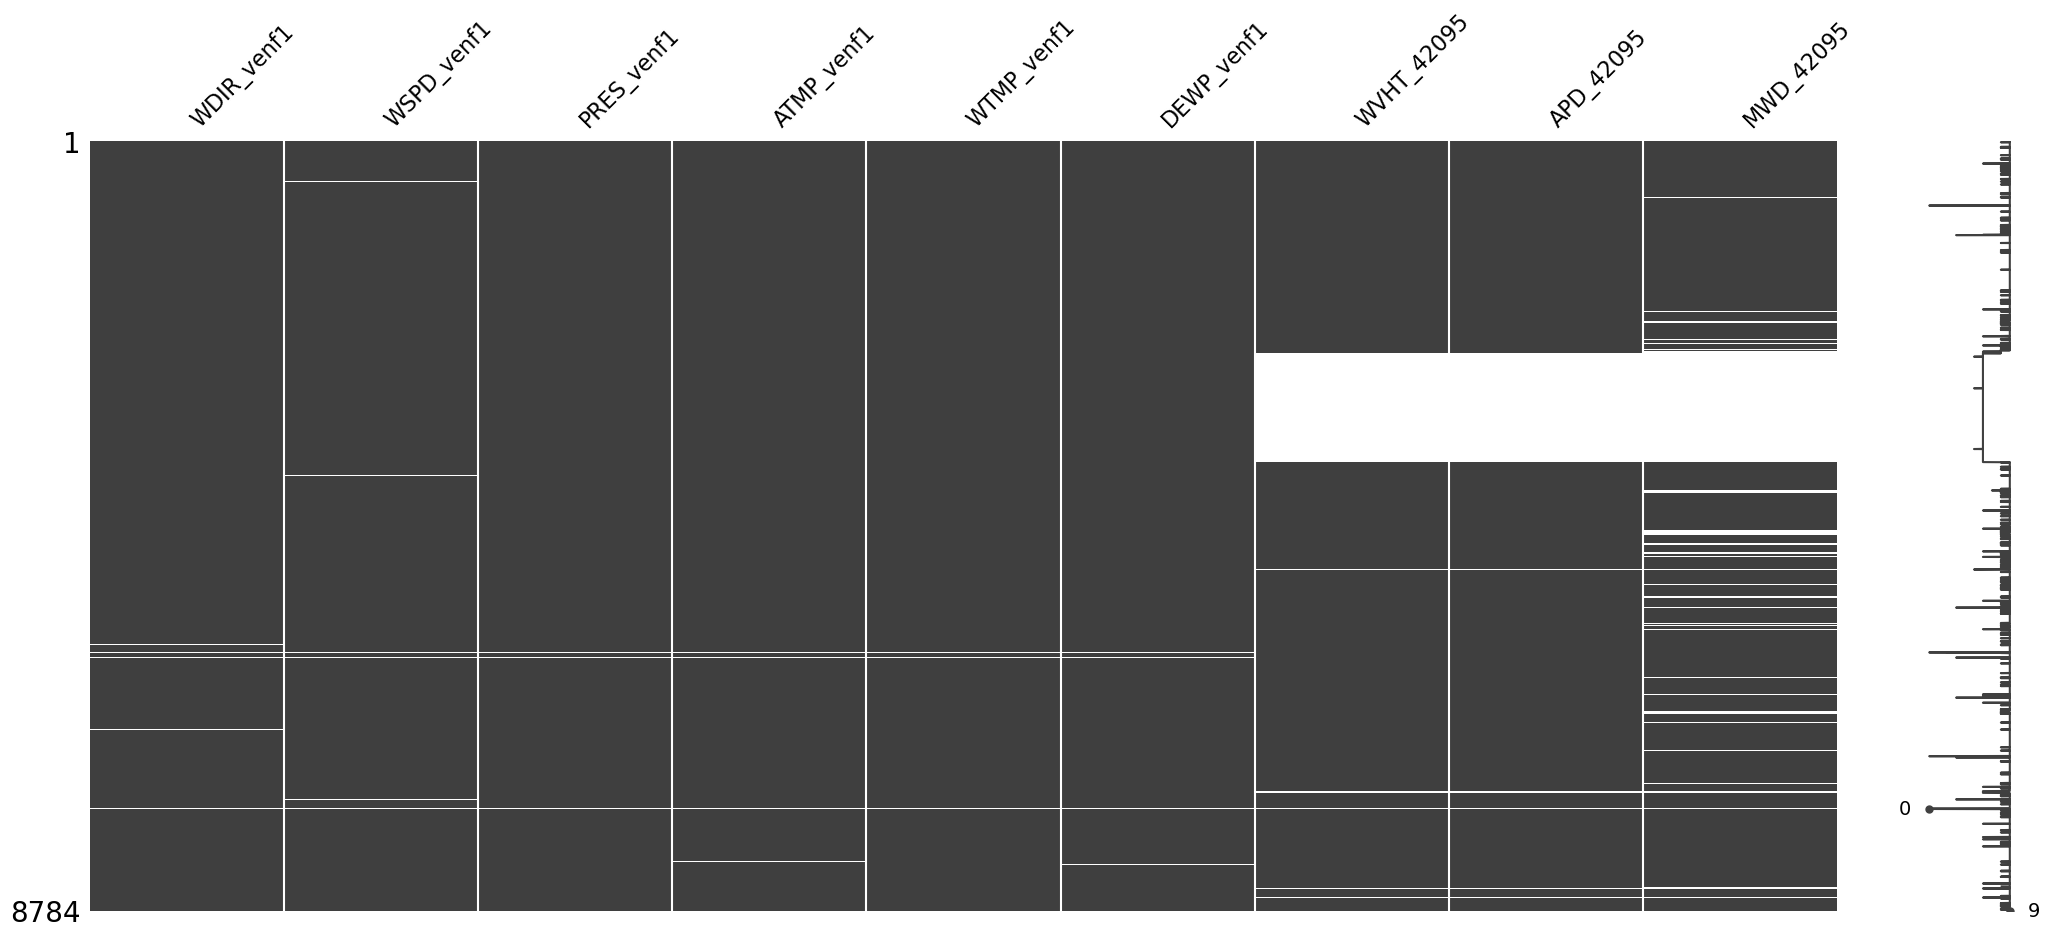

In [19]:
import missingno as msno
msno.matrix(df_NDBC)

Even though there are many NaN values - this is the best available data for the year 2020 and the gulf of mexico! In total, only two buoys collect this data, which means we probably won't use these features anyway.

In [20]:
delta_absolute, delta_relative = mL.compare_NDBC_ERA5(df_NDBC, df_ERA5)
delta_absolute

,WDIR_venf1,WSPD_venf1,PRES_venf1,ATMP_venf1,WTMP_venf1,DEWP_venf1,WVHT_42095,APD_42095,MWD_42095
timestamp,,,,,,,,,
2020-01-01 00:00:00,66.901817,0.879812,0.118938,0.474430,0.667572,0.334847,0.118299,1.343230,85.407556
2020-01-01 01:00:00,71.452617,0.620002,0.156195,0.710698,0.567572,0.292216,0.082221,0.406796,88.760078
2020-01-01 02:00:00,66.235666,1.535849,0.033317,0.802971,0.467572,0.087591,0.082740,0.146890,83.425683
2020-01-01 03:00:00,66.713193,0.746895,0.009370,0.461183,0.367572,0.239840,0.111013,0.128079,82.393386
2020-01-01 04:00:00,63.638897,1.289535,0.218578,1.093403,0.367572,0.416160,0.065409,0.544022,82.756564
...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,38.737566,1.340329,0.286773,1.122011,0.026222,2.592537,1.986257,0.714320,12.879205
2020-12-31 20:00:00,57.449356,0.790630,0.382951,0.797359,0.026222,2.869975,2.188874,0.988060,22.384863
2020-12-31 21:00:00,43.979369,2.275994,0.028696,2.841012,0.173778,2.553537,2.377285,1.225113,18.753203


In [21]:
delta_relative

,WSPD_venf1,PRES_venf1,ATMP_venf1,WTMP_venf1,DEWP_venf1,WVHT_42095,APD_42095
timestamp,,,,,,,
2020-01-01 00:00:00,30.34,0.01,2.79,3.13,3.45,23.20,42.51
2020-01-01 01:00:00,20.00,0.02,4.33,2.68,2.89,14.18,9.76
2020-01-01 02:00:00,66.78,0.00,4.99,2.22,0.89,14.02,3.06
2020-01-01 03:00:00,23.34,0.00,2.85,1.75,2.45,19.82,2.79
2020-01-01 04:00:00,44.47,0.02,7.10,1.75,4.52,10.90,12.89
...,...,...,...,...,...,...,...
2020-12-31 19:00:00,24.37,0.03,5.15,0.15,12.71,69.94,11.25
2020-12-31 20:00:00,10.68,0.04,3.58,0.15,13.93,72.24,14.95
2020-12-31 21:00:00,58.36,0.00,14.06,0.95,12.64,74.76,17.94


For wind directory, relative analysis does not make any sense! Furthermore, relative analysis is not usefull if values in ERA5 are 0! (--> results in -inf)

In [22]:
delta_absolute.describe()

,WDIR_venf1,WSPD_venf1,PRES_venf1,ATMP_venf1,WTMP_venf1,DEWP_venf1,WVHT_42095,APD_42095,MWD_42095
count,8726.000000,8753.000000,8758.000000,8754.000000,8758.000000,8744.000000,7466.000000,7466.000000,7033.000000
mean,82.899993,1.445154,0.262507,1.039245,0.730264,1.189098,0.320162,0.711851,31.337072
std,46.022572,1.109650,0.212212,0.828859,0.552271,1.037330,0.381078,0.516723,35.370540
min,0.009129,0.000143,0.000029,0.000158,0.000006,0.000046,0.000013,0.000242,0.007959
25%,47.443531,0.576408,0.107653,0.390379,0.281918,0.466355,0.065412,0.319036,7.604581
50%,82.264851,1.226232,0.223249,0.847809,0.608173,0.940450,0.188622,0.623979,17.383874
75%,113.955731,2.071391,0.358696,1.492909,1.095844,1.592287,0.436208,0.982755,42.044876
max,179.874896,11.148137,2.213576,6.490648,2.996344,9.635660,3.969809,3.661861,179.971492


In [23]:
delta_relative.describe()

,WSPD_venf1,PRES_venf1,ATMP_venf1,WTMP_venf1,DEWP_venf1,WVHT_42095,APD_42095
count,8753.00,8758.000000,8754.000000,8758.000000,8744.0000,7466.000000,7466.000000
mean,inf,0.025697,5.132419,2.838789,inf,31.124751,19.644944
std,NaN,0.021198,5.996197,2.109355,NaN,21.485365,14.984247
min,0.00,0.000000,0.000000,0.000000,0.0000,0.000000,0.010000
25%,14.63,0.010000,1.600000,1.120000,2.2800,13.070000,7.670000
50%,30.11,0.020000,3.470000,2.420000,4.5800,28.385000,16.810000
75%,52.89,0.040000,6.530000,4.227500,8.2025,45.310000,28.010000
max,inf,0.220000,73.260000,14.970000,inf,172.870000,110.530000


WDIR and MWD are not added to delta_relative since this does not make sense. A deviation of 10° must be similarly taken into account without having it influenced by the direction. But on a relative scale, the values 1° and 11° would be representad as a much bigger deviation than the same deviation between 300° and 310°!

# Issue with Wind:

Standard deviation of direction is 43° which is a lot.


Calculation is correct!
also components of neutral wind do not provide better results!

Different Height?
ERA5: Wind 10m above surface
NDBC: venf1: Wind 11.6m above site elevation
... not a big difference - does not explain the deviation!

Different units?
ERA5: m*s^-1 = m/s
NDBC:
    WSPD: m/s
    WDIR degrees clockwise (The direction, the wind is comming from)
... also does not explain the difference

What exactly is measured?
NDBC:
    Averaged wind direction (time period is not mentioned)
ERA5:
    only horizontal wind speed. (Probably also the case for NDBC, since the anemometer can not absorb vertical forces..)


ERA5 variable description mentions:
### Care should be taken when comparing this parameter with observations, because wind observations vary on small space and time scales and are affected by the local terrain, vegetation and buildings that are represented only on average in the ECMWF Integrated Forecasting System (IFS).

## --> What now?
* remove these 2 features?
* Does it even matter for the PINN if the values match or are just the patterns relevant to regularize the loss?

# Pressure
is almost similar. Relative Standard diviation is 0.02%!

# ATMP
Standard deviation of 10% should be fine!

# WTMP
Standard deviation of 3% should be fine!

# DEWP
Absolute std of 1.6 for values between -10 and +40 is fine!

# WVHT
STD is 30%. Could be better. But for the wave-height, this makes sense!

# APD
STD is 18%. This should be fine for the Average Wave Period (Average Wave Duration)!

# MWD
relative analysis does not make sense for direction!

MWD = mean wind direction. Same issue as with wind direction... Furthermore, if the wind direction is almost North, the distance could be close to 360 even though, it is actually almost 0!




# Visualization

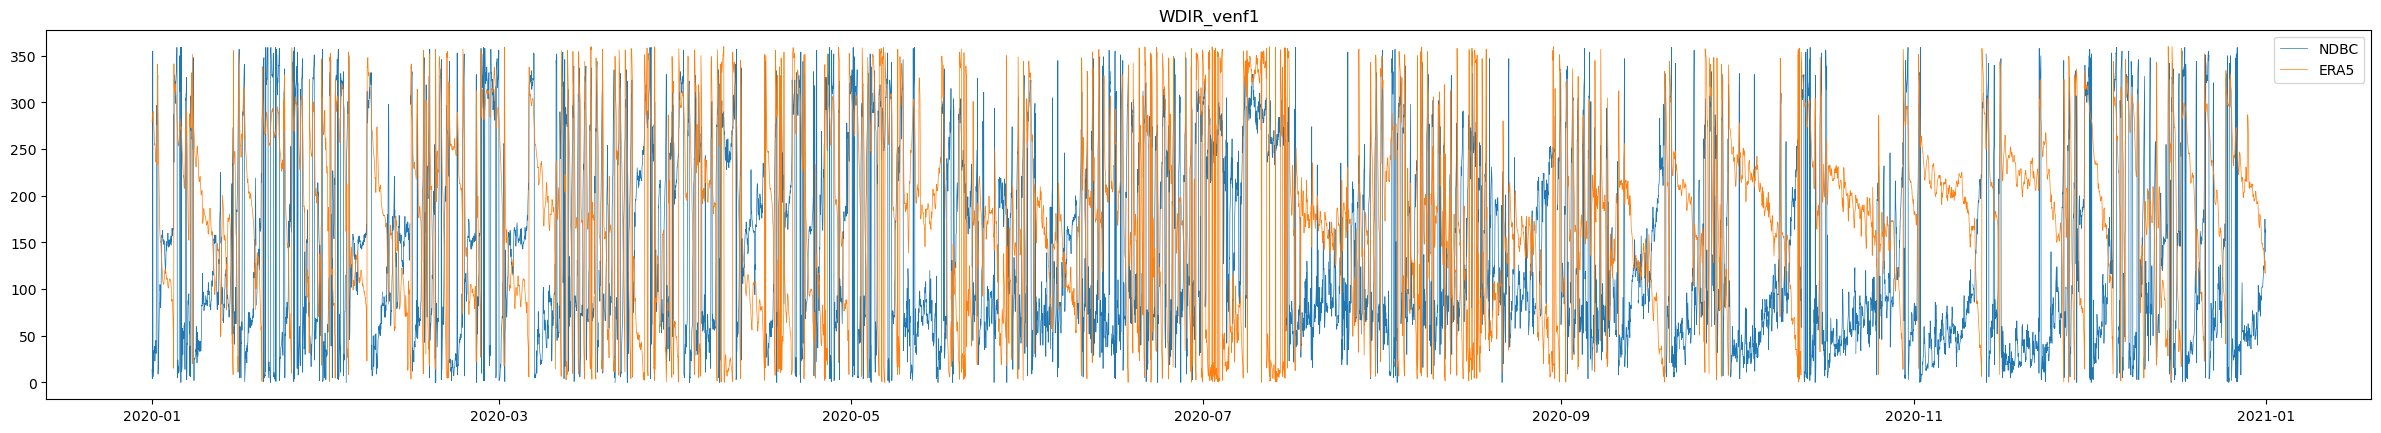

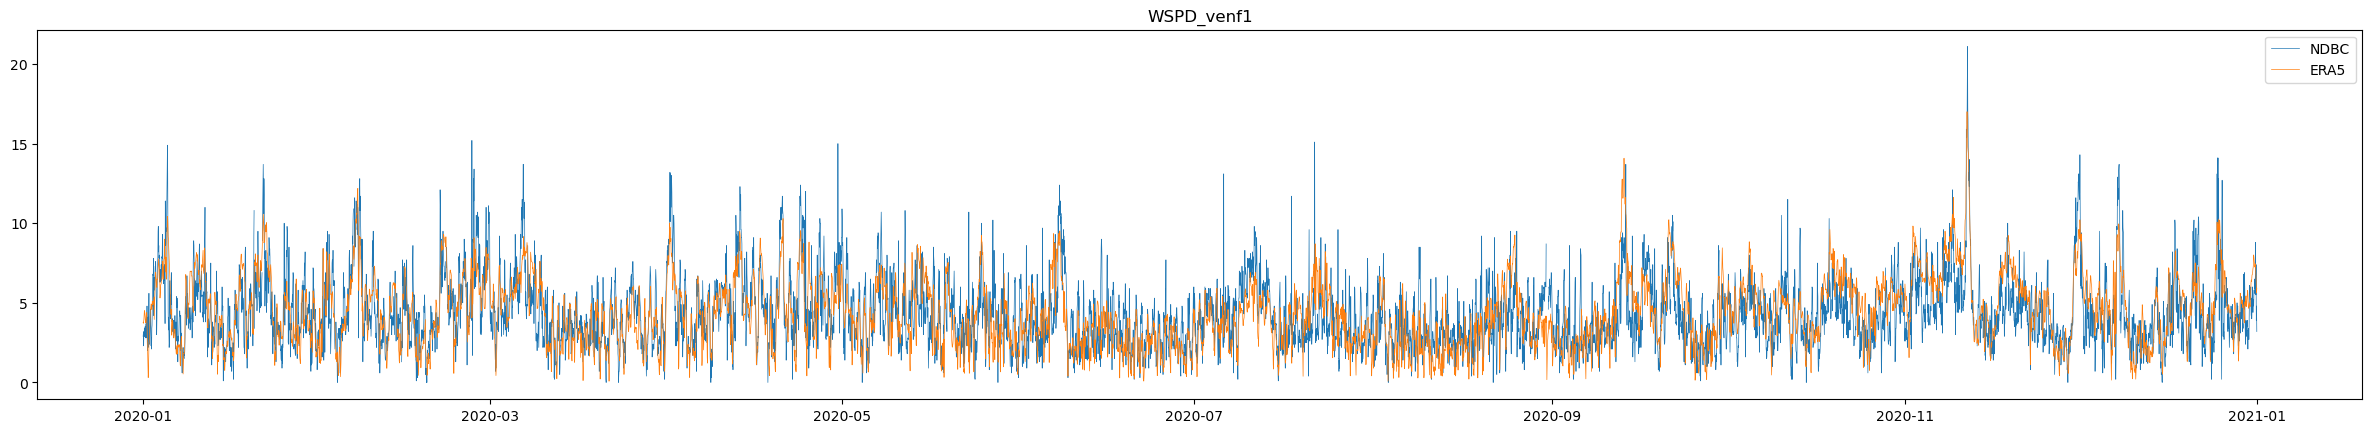

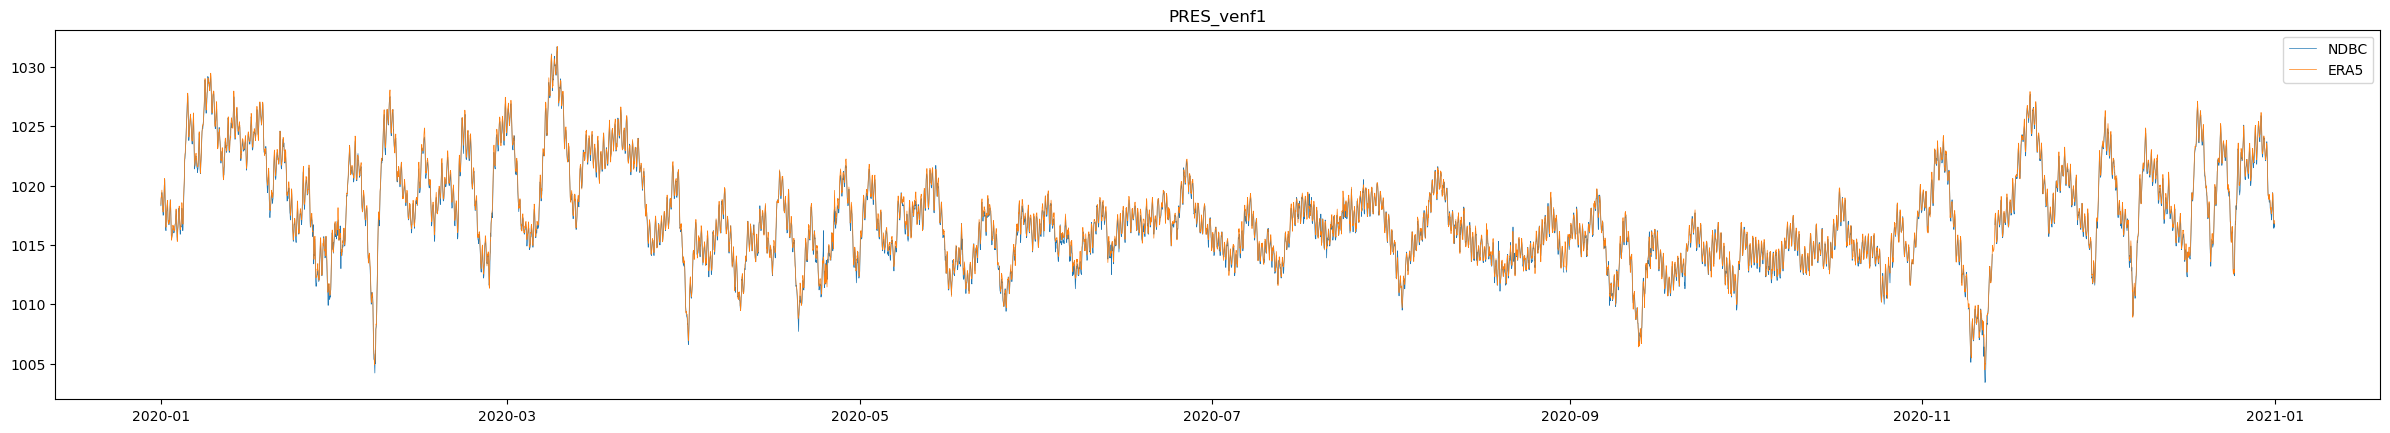

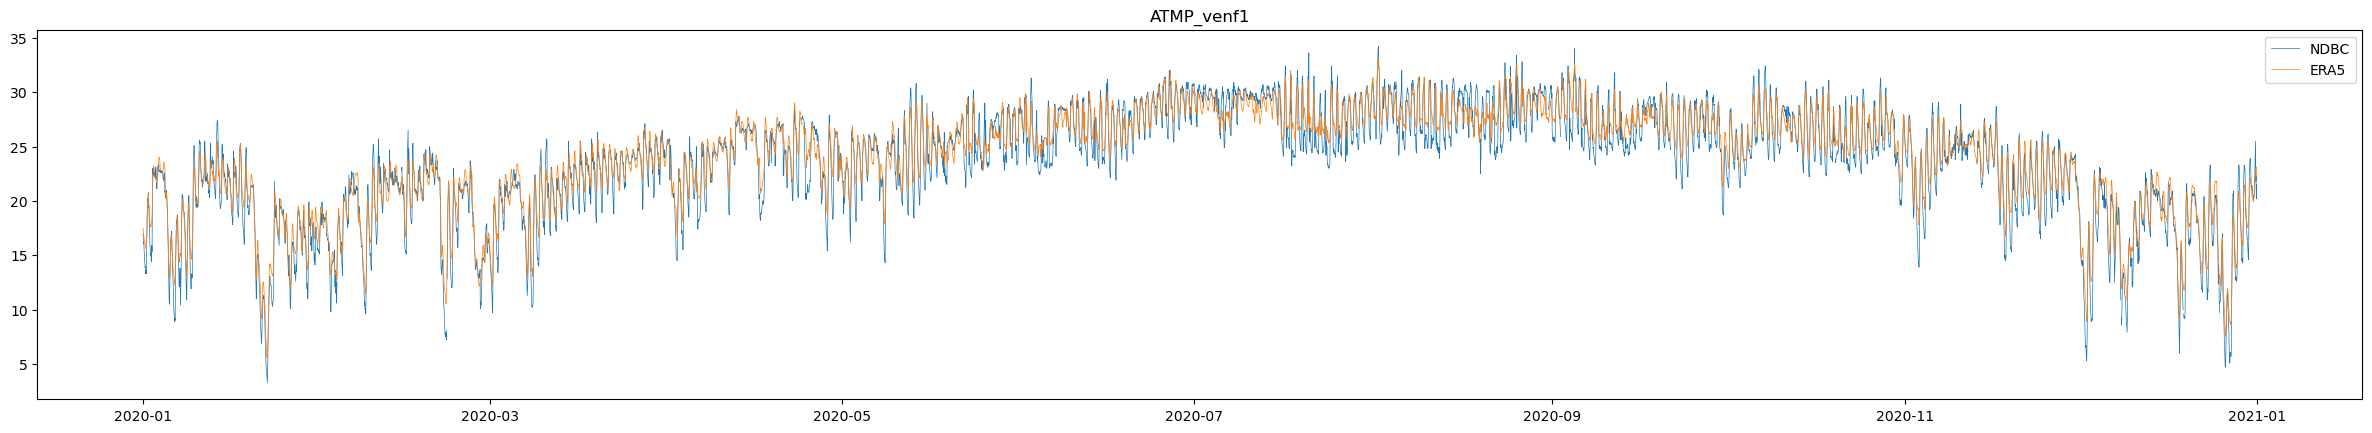

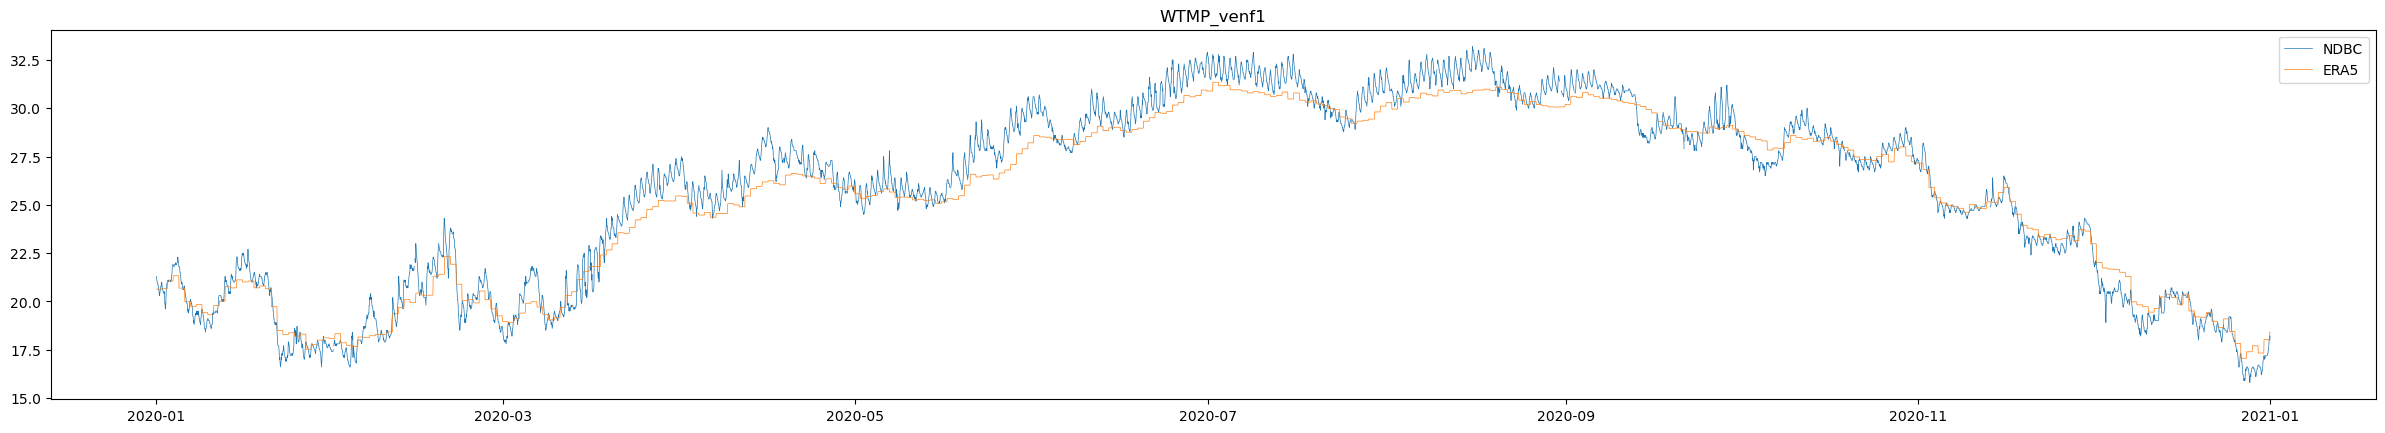

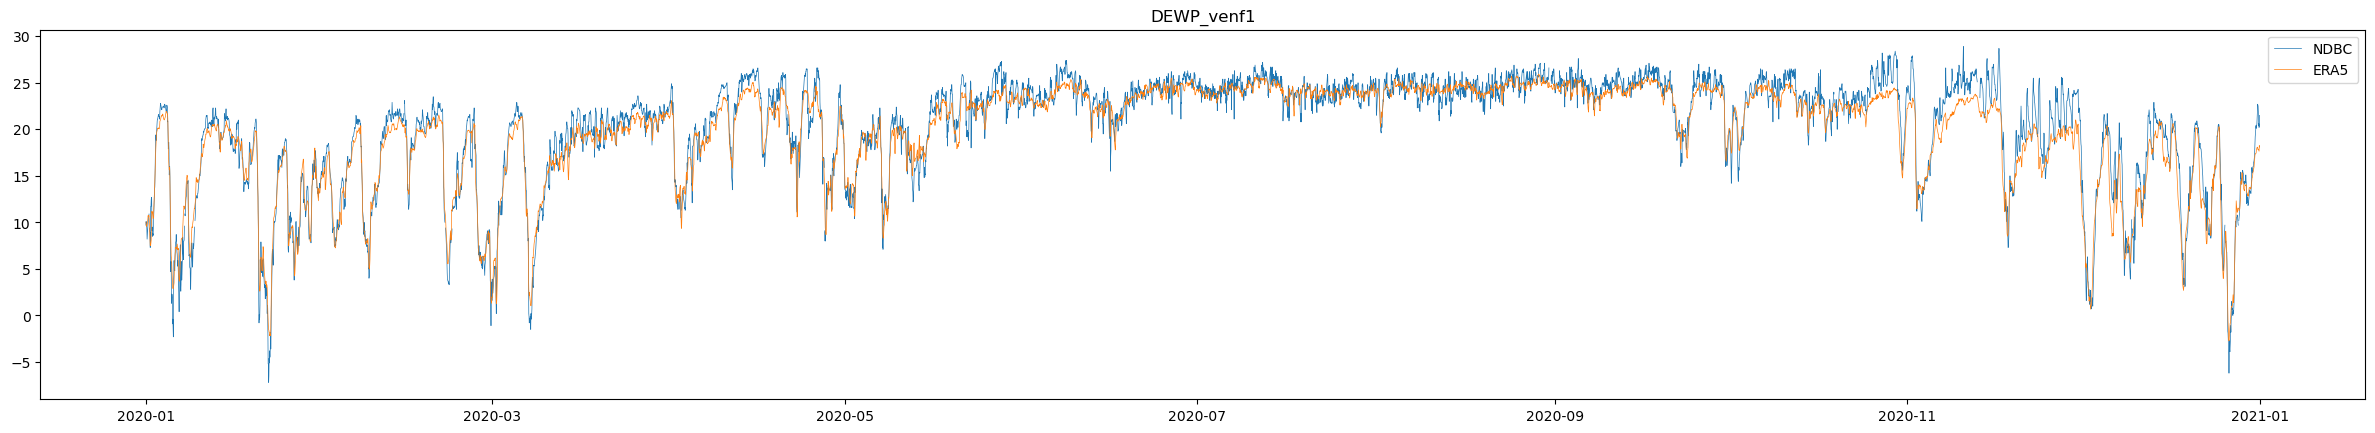

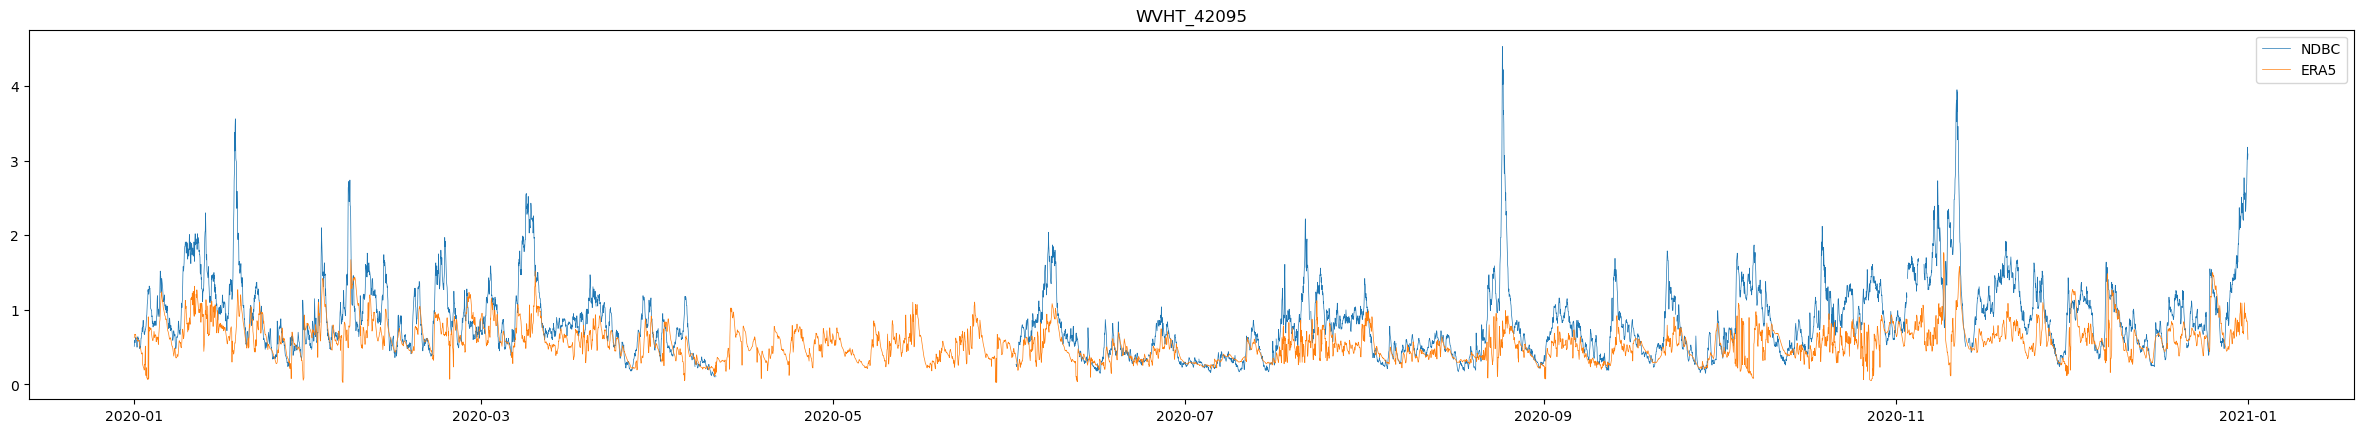

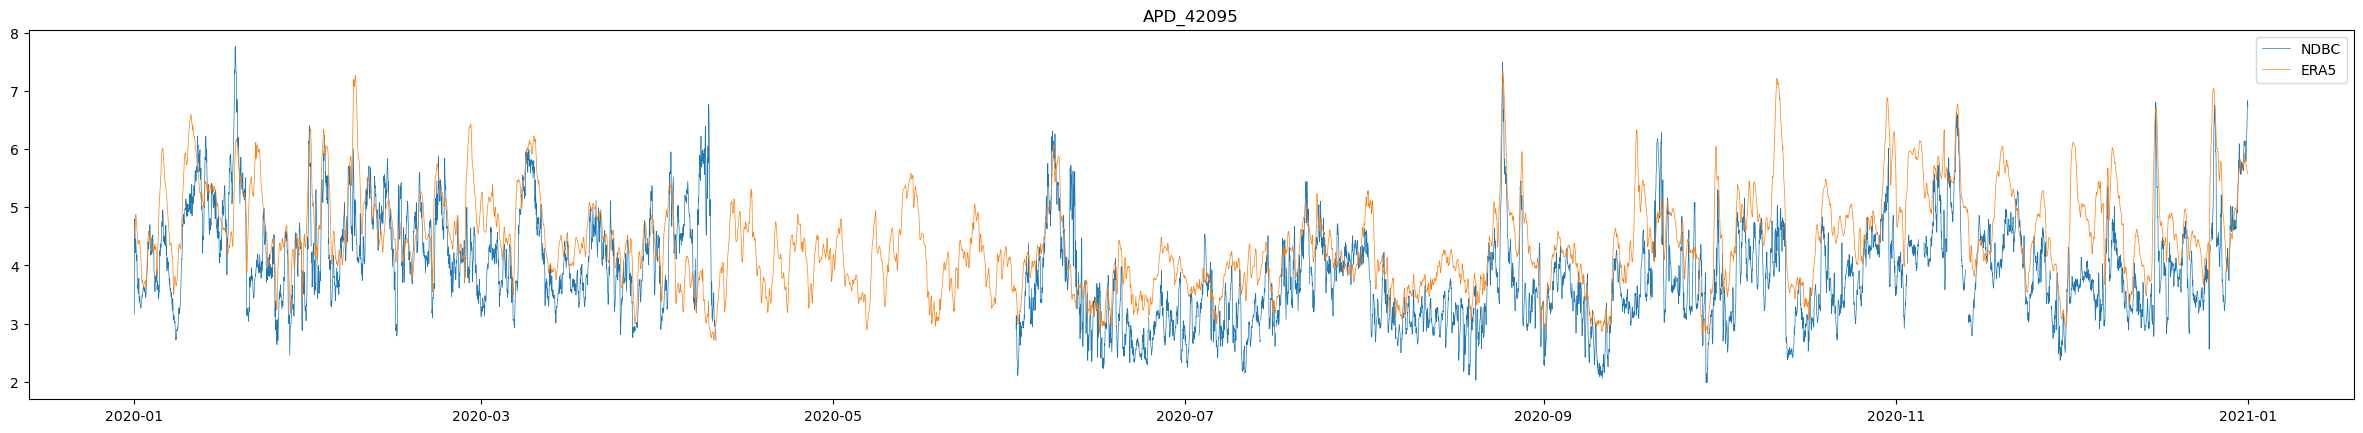

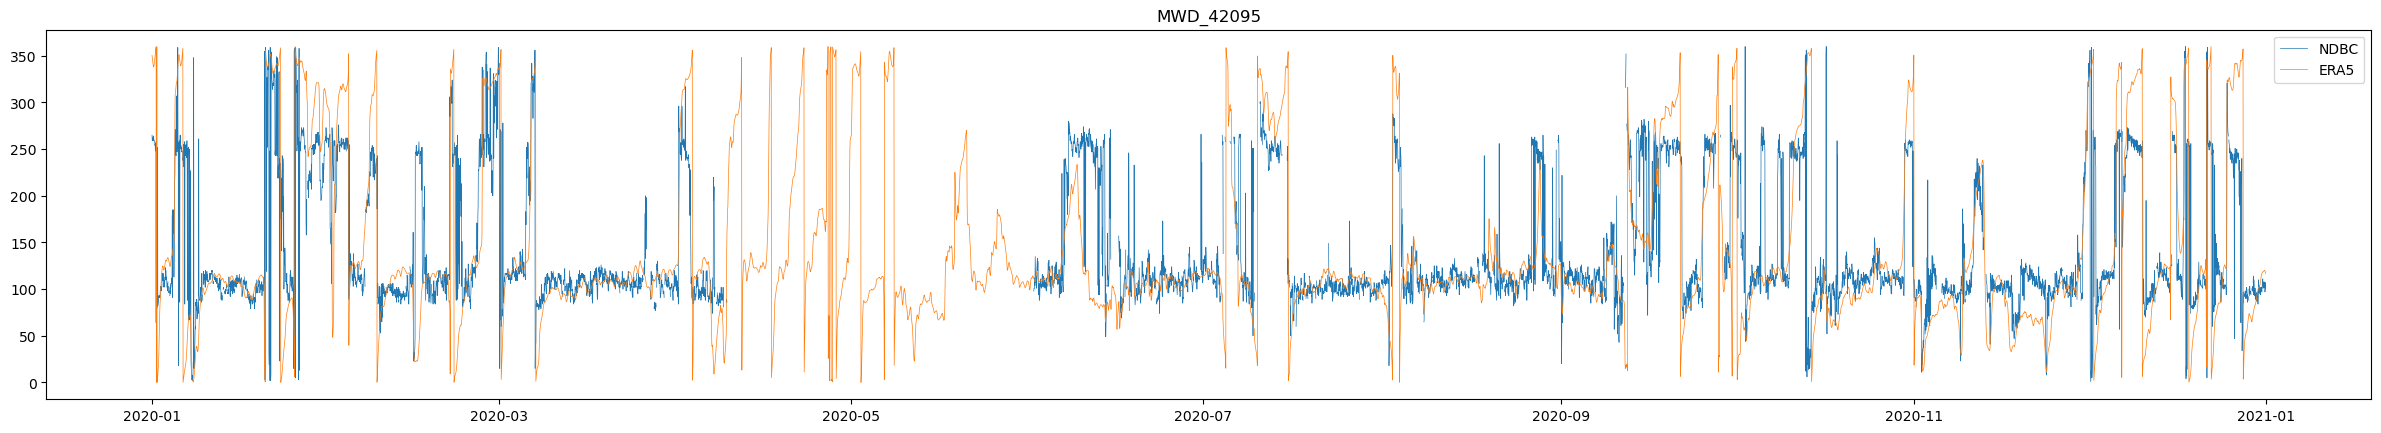

In [24]:
for feature in df_NDBC.columns:
    mL.plot_parameter_comparison(df_NDBC[feature], df_ERA5[feature], feature)

TODO:
There are values missed in 42095!! Why? Are they NaN? I thought I used a buoy that provides all those values? If they are NaN check how this is handled when calculating the delta_absolute statistic!


# Findings:

Actually, the values do match better than I thought! This should be good enough to continue!

# Boxplots:

<AxesSubplot:>

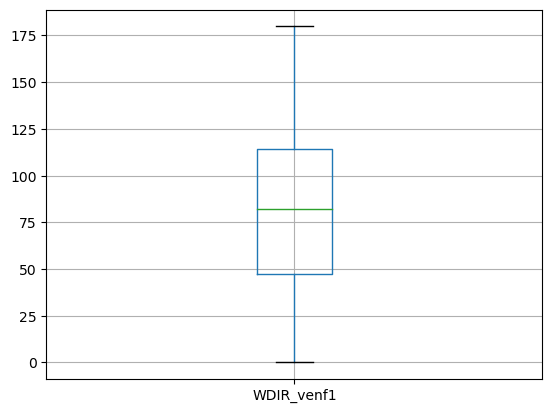

In [25]:
#Absolute (since those are directions!)
delta_absolute.boxplot(column=f"WDIR_{STATION_ID_1}")

<AxesSubplot:>

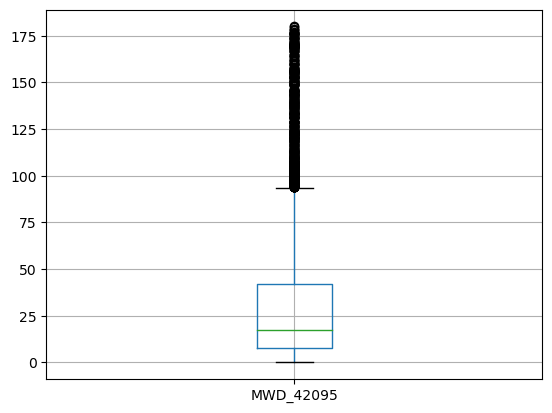

In [26]:
delta_absolute.boxplot(column=f"MWD_{STATION_ID_2}")

<AxesSubplot:>

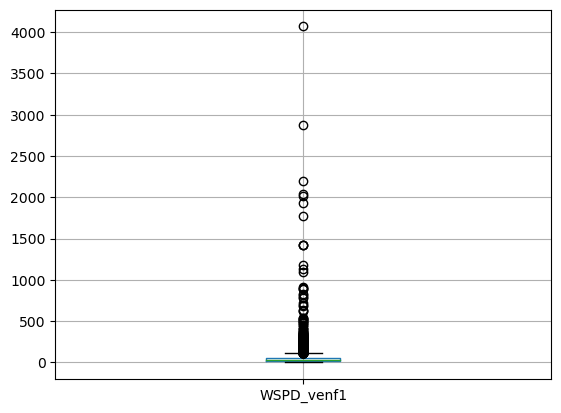

In [27]:
#Relative
delta_relative.boxplot(column=f"WSPD_{STATION_ID_1}")

<AxesSubplot:>

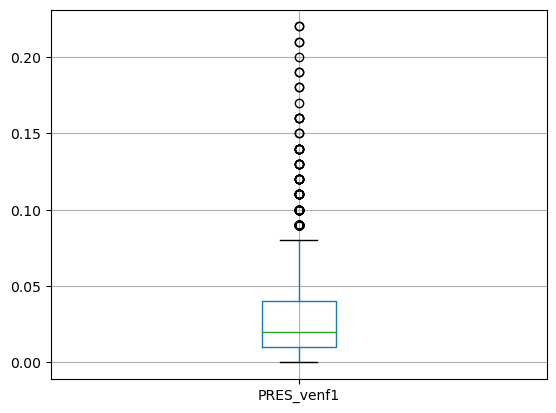

In [28]:
delta_relative.boxplot(column=f"PRES_{STATION_ID_1}")

<AxesSubplot:>

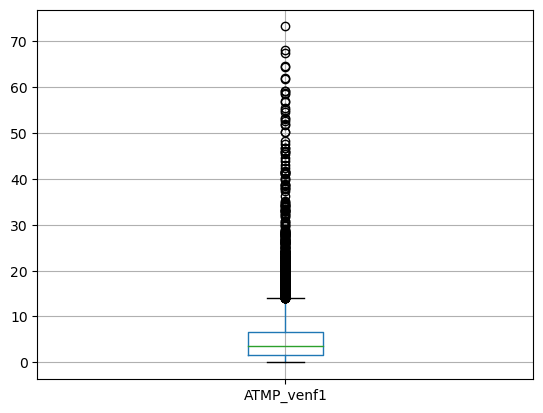

In [29]:
delta_relative.boxplot(column=f"ATMP_{STATION_ID_1}")

<AxesSubplot:>

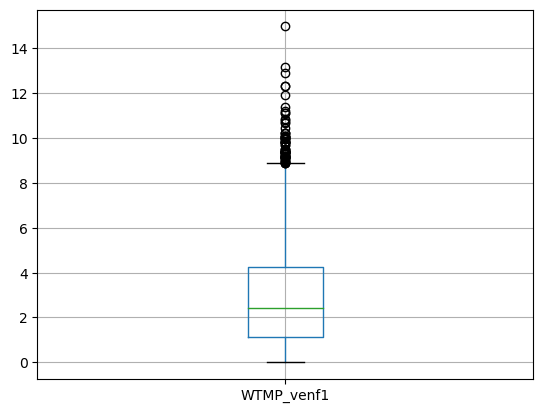

In [30]:
delta_relative.boxplot(column=f"WTMP_{STATION_ID_1}")

<AxesSubplot:>

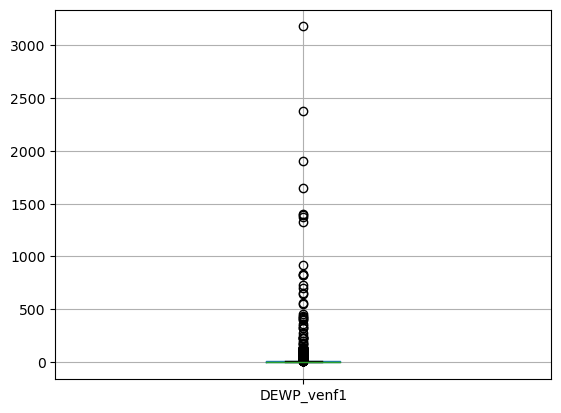

In [31]:
delta_relative.boxplot(column=f"DEWP_{STATION_ID_1}")

<AxesSubplot:>

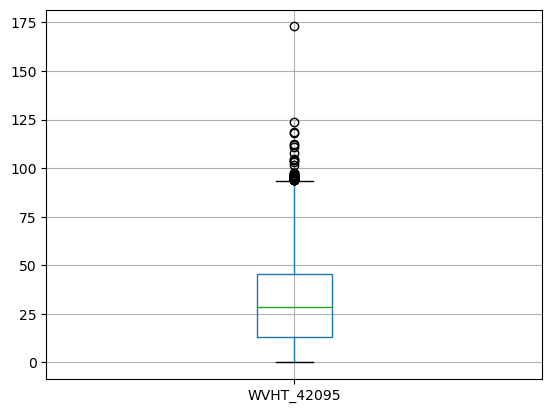

In [32]:
delta_relative.boxplot(column=f"WVHT_{STATION_ID_2}")

<AxesSubplot:>

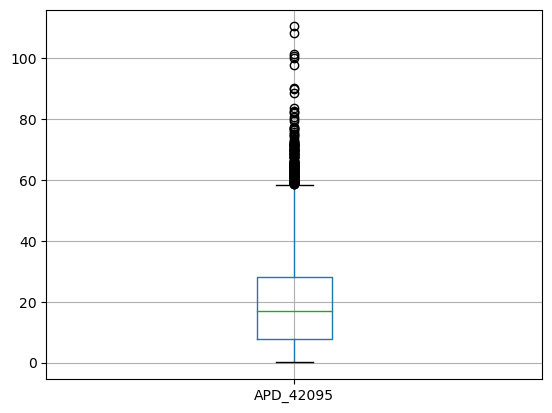

In [33]:
delta_relative.boxplot(column=f"APD_{STATION_ID_2}")

In [35]:
metadata = pd.read_csv('../data/metadata/metadata_2023_03_14.csv')
metadata.set_index("StationID", inplace=True)

lat = metadata.loc[STATION_ID_1.upper()]["lat"]
lon = metadata.loc[STATION_ID_1.upper()]["lon"]
coords = [lat, lon] * 2
coords

[27.072, -82.453, 27.072, -82.453]